In [1]:
from pathlib import Path
from functools import partial

from utils import load_polar

import pybem as pb
import numpy as np
import pandas as pd
import proplot as plot

Inputs

In [2]:
PATH_POLARS = Path("../polars")
file_lift = "lift.csv"
file_drag = "drag.csv"
file_propeller = PATH_POLARS / "propeller1_inches.txt"

PITCH = 32.4  # inches

In [3]:
INCH_METER = 0.0254
PITCH = INCH_METER * PITCH  # meters

In [4]:
csv_reader = partial(pd.read_csv, sep=";", index_col=None)
load_polar = partial(
    load_polar,
    path=PATH_POLARS,
    file_lift=file_lift,
    file_drag=file_drag,
    reader=csv_reader,
)

In [5]:
dimensions_df = pd.read_csv(filepath_or_buffer=file_propeller, sep=",")

# Enforce stripped columns
dimensions_df.columns = [col.strip() for col in dimensions_df.columns]
dimensions_df = dimensions_df[["radius", "chord"]]

# Convert to international units
dimensions_df = dimensions_df.mul(INCH_METER)

# Name
dimensions_df.index = ["Hub", "S1", "S2", "S3", "S4", "Tip"]

for idx, row in dimensions_df.iterrows():

    r = row["radius"]

    # Constant pitch law
    tan_theta = PITCH / (2.0 * np.pi * r) 
    theta = np.arctan(tan_theta)  # radians
    theta = np.rad2deg(theta)  # degrees

    dimensions_df.loc[idx, "theta"] = theta

dimensions_df

,radius,chord,theta
Hub,0.1016,0.06223,52.199199
S1,0.1778,0.06858,36.377590
S2,0.2540,0.06858,27.278439
S3,0.3302,0.06858,21.636400
S4,0.4064,0.06858,17.863548
Tip,0.4572,0.06858,15.985890


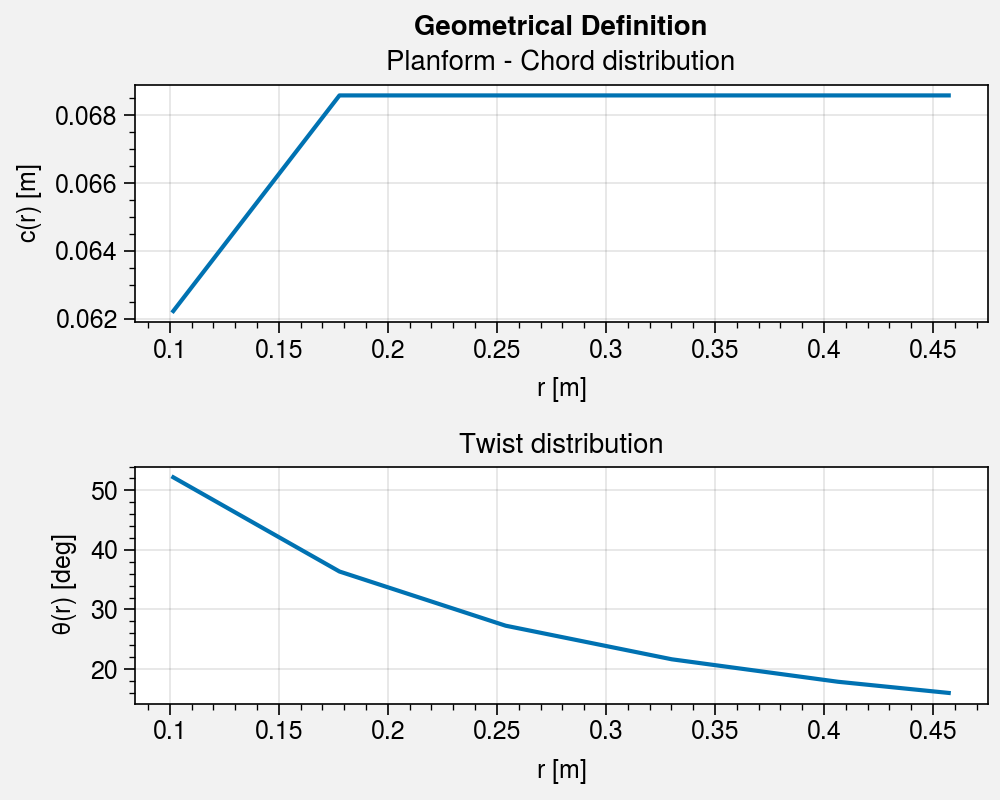

In [6]:
fig, axes = plot.subplots(nrows = 2, share=0, figsize=(5,4))

ax = axes[0]
ax.plot(
    dimensions_df.set_index("radius")["chord"],
)
ax.format(
    title="Planform - Chord distribution",
    ylabel="$c(r)$ [m]",
    xlabel="$r$ [m]",
    suptitle="Geometrical Definition",
)

ax = axes[1]
ax.plot(
    dimensions_df.set_index("radius")["theta"],
)
ax.format(
    title="Twist distribution",
    ylabel="$\\theta(r)$ [deg]",
    xlabel="$r$ [m]",
)



In [28]:
print(dimensions_df.round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  radius &  chord &   theta \\
\midrule
Hub &   0.102 &  0.062 &  52.199 \\
S1  &   0.178 &  0.069 &  36.378 \\
S2  &   0.254 &  0.069 &  27.278 \\
S3  &   0.330 &  0.069 &  21.636 \\
S4  &   0.406 &  0.069 &  17.864 \\
Tip &   0.457 &  0.069 &  15.986 \\
\bottomrule
\end{tabular}



Create the blade by defining the sections at each stage.

array([[-9.71320755,  0.1509276 ],
       [-8.21886792,  0.16781697],
       [-6.80754717,  0.20563242],
       [-5.31320755,  0.28532373],
       [-4.4       ,  0.35239936],
       [-3.81886792,  0.4026962 ],
       [-2.90566038,  0.46558503],
       [-2.0754717 ,  0.51590557],
       [-1.07924528,  0.5788023 ],
       [-0.16603774,  0.62913074],
       [ 0.91320755,  0.68784857],
       [ 1.99245283,  0.7465664 ],
       [ 2.98867925,  0.79690274],
       [ 3.90188679,  0.85141798],
       [ 5.23018868,  0.9185331 ],
       [ 6.39245283,  0.97307204],
       [ 7.63773585,  1.02761887],
       [ 8.63396226,  1.08214201],
       [ 9.71320755,  1.12829946],
       [10.8754717 ,  1.19121198],
       [12.45283019,  1.2625376 ],
       [13.53207547,  1.32125543],
       [14.61132075,  1.35903929],
       [15.77358491,  1.40101783],
       [17.18490566,  1.44302008],
       [18.76226415,  1.47247774],
       [19.26037736,  0.73146234],
       [21.04528302,  0.73163218]])

In [7]:
# Define known sections
sections = [
    pb.Section(
        name="Hub",
        r=dimensions_df.loc["Hub", "radius"],
        beta=dimensions_df.loc["Hub", "theta"],
        chord=dimensions_df.loc["Hub", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="765", which="cl"),
            polar_cd=load_polar(airfoil_type="765", which="cd"),
        ),
    ),
    pb.Section(
        name="S1",
        r=dimensions_df.loc["S1", "radius"],
        beta=dimensions_df.loc["S1", "theta"],
        chord=dimensions_df.loc["S1", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="765", which="cl"),
            polar_cd=load_polar(airfoil_type="765", which="cd"),
        ),
    ),
    pb.Section(
        name="S2",
        r=dimensions_df.loc["S2", "radius"],
        beta=dimensions_df.loc["S2", "theta"],
        chord=dimensions_df.loc["S2", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="764", which="cl"),
            polar_cd=load_polar(airfoil_type="764", which="cd"),
        ),
    ),
    pb.Section(
        name="S3",
        r=dimensions_df.loc["S3", "radius"],
        beta=dimensions_df.loc["S3", "theta"],
        chord=dimensions_df.loc["S3", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="763", which="cl"),
            polar_cd=load_polar(airfoil_type="763", which="cd"),
        ),
    ),
    pb.Section(
        name="S4",
        r=dimensions_df.loc["S4", "radius"],
        beta=dimensions_df.loc["S4", "theta"],
        chord=dimensions_df.loc["S4", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="762", which="cl"),
            polar_cd=load_polar(airfoil_type="762", which="cd"),
        ),
    ),
    pb.Section(
        name="Tip",
        r=dimensions_df.loc["Tip", "radius"],
        beta=dimensions_df.loc["Tip", "theta"],
        chord=dimensions_df.loc["Tip", "chord"],
        airfoil=pb.Airfoil(
            polar_cl=load_polar(airfoil_type="761", which="cl"),
            polar_cd=load_polar(airfoil_type="761", which="cd"),
        ),
    ),
]

In [17]:
# Define propeller
B = 2
propeller = pb.Propeller(B=B, sections=sections)

# Define flow conditions and BEM method

results = []
for J in np.linspace(1e-1, 1.5):

    pi = np.pi

    _lambda = J / pi

    bem = pb.BladeElementMethod(
        _lambda=_lambda, propeller=propeller, tip_loss=True, hub_loss=False
    )

    try:
        # Solve
        bem.solve()
        CT, CQ = bem.integrate_forces()
    except:
        CT = np.nan
        CQ = np.nan

    # Create experiments non-dimensionless coefficients
    results.append(
        (
            J,
            CT * (pi ** 3.0) / 4 / J ** 2.0,
            CQ * (pi ** 4.0) / 4 / J ** 2.0,
            _lambda * CT / CQ, # efficiency
        )
    )
    
    del bem

In [18]:
results_df = (
    pd.DataFrame(results, columns=["J", "CT", "CP", "eta"])
    .dropna()
    .set_index("J")
)

In [19]:
G = 9.81

In [20]:
PATH_EXPERIMENTS = Path("../experimental_results")
path_thrust = PATH_EXPERIMENTS / 'thrust_coefficient.csv'
path_torque = PATH_EXPERIMENTS / 'torque_coefficient.csv'
path_efficiency = PATH_EXPERIMENTS / 'efficiency.csv'

In [21]:
experimental_thrust = pd.read_csv(path_thrust, sep = ';', index_col=0)
experimental_torque = pd.read_csv(path_torque, sep = ';', index_col=0)
experimental_efficiency = pd.read_csv(path_efficiency, sep = ";", index_col = 0)

experimental_thrust = experimental_thrust.sort_index().div(G)
experimental_torque = experimental_torque.sort_index().div(G)
experimental_efficiency = experimental_efficiency.sort_index()

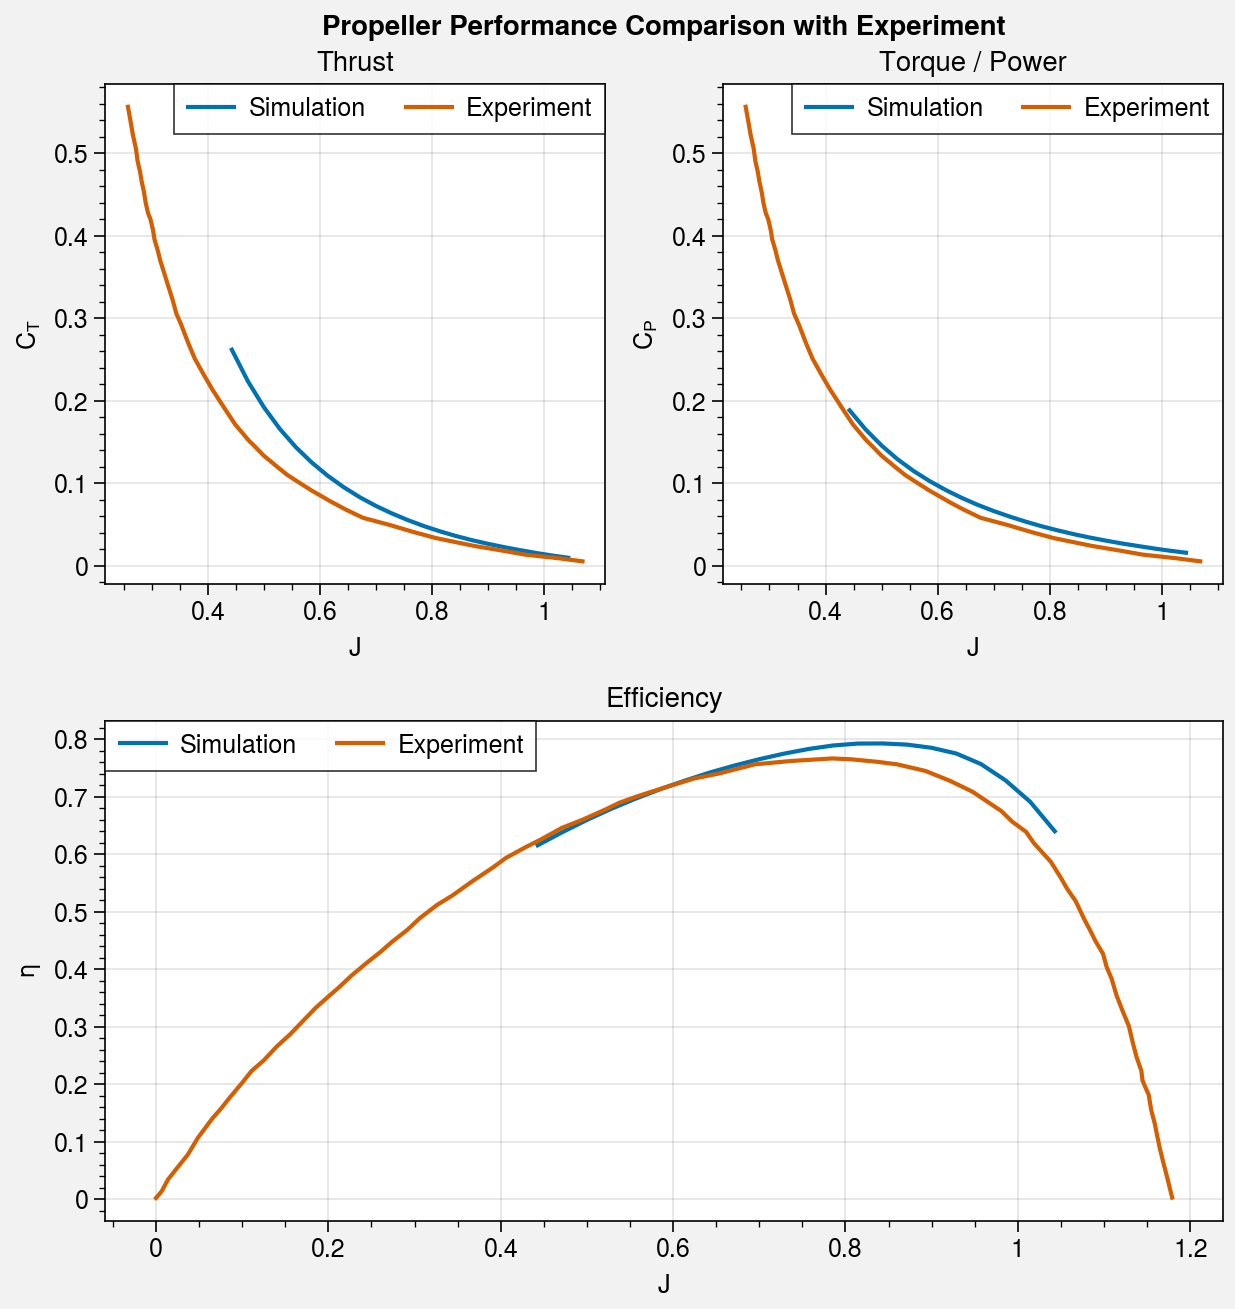

In [22]:
_array = [[1, 2], [3, 3]]
fig, axes = plot.subplots(array=_array, share=0)

############
# Thrust
############
ax = axes[0]
ax.plot(
    results_df.drop(["eta", "CP"], axis=1),
)
ax.plot(experimental_thrust)
ax.format(
    title="Thrust",
    ylabel="$C_T$",
    suptitle="Propeller Performance Comparison with Experiment",
)
ax.legend(labels=["Simulation", "Experiment"])

############
# Torque
############
ax = axes[1]
ax.plot(
    results_df.drop(["eta", "CT"], axis=1),
)
ax.plot(experimental_thrust)
ax.format(
    title="Torque / Power",
    ylabel="$C_P$",
    suptitle="Propeller Performance Comparison with Experiment",
)
ax.legend(labels=["Simulation", "Experiment"])

############
# Efficiency
############
ax = axes[-1]
ax.plot(results_df["eta"])
ax.plot(experimental_efficiency)
ax.format(title="Efficiency", ylabel="$\eta$")
ax.legend(labels=["Simulation", "Experiment"], frame = True)

fig.save("tst")

In [14]:
J = 0.6

pi = np.pi

_lambda = J / pi

bem = pb.BladeElementMethod(
    _lambda=_lambda, propeller=propeller, tip_loss=True, hub_loss=False
)

bem.solve()
CT, CQ = bem.integrate_forces()
CT = CT * (pi ** 3.0) / 4 / J ** 2.0
CQ = CQ * (pi ** 4.0) / 4 / J ** 2.0

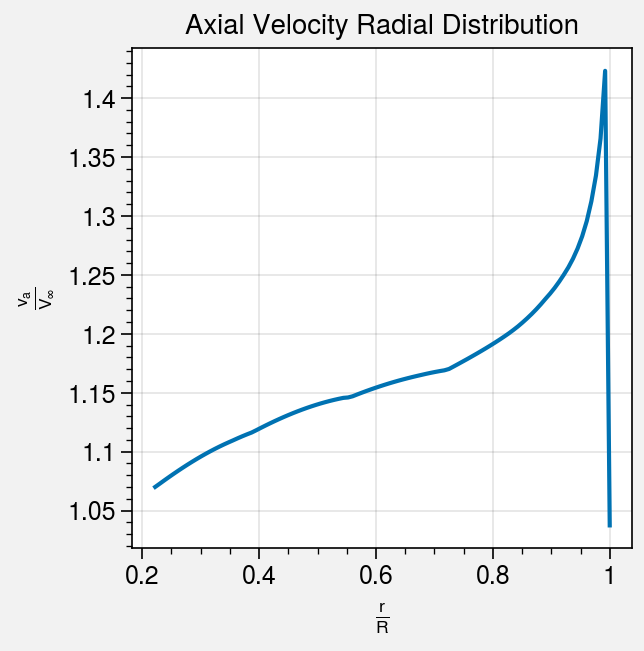

In [15]:
fig, axes = plot.subplots()
axes.plot(bem.r_dist, bem.axial_velocity_radial_distribution)
axes.format(xlabel = "$\\frac{r}{R}$",
            ylabel = "$\\frac{v_a}{V_{\infty}}$", 
            title="Axial Velocity Radial Distribution")
fig.save("loading_distribution")

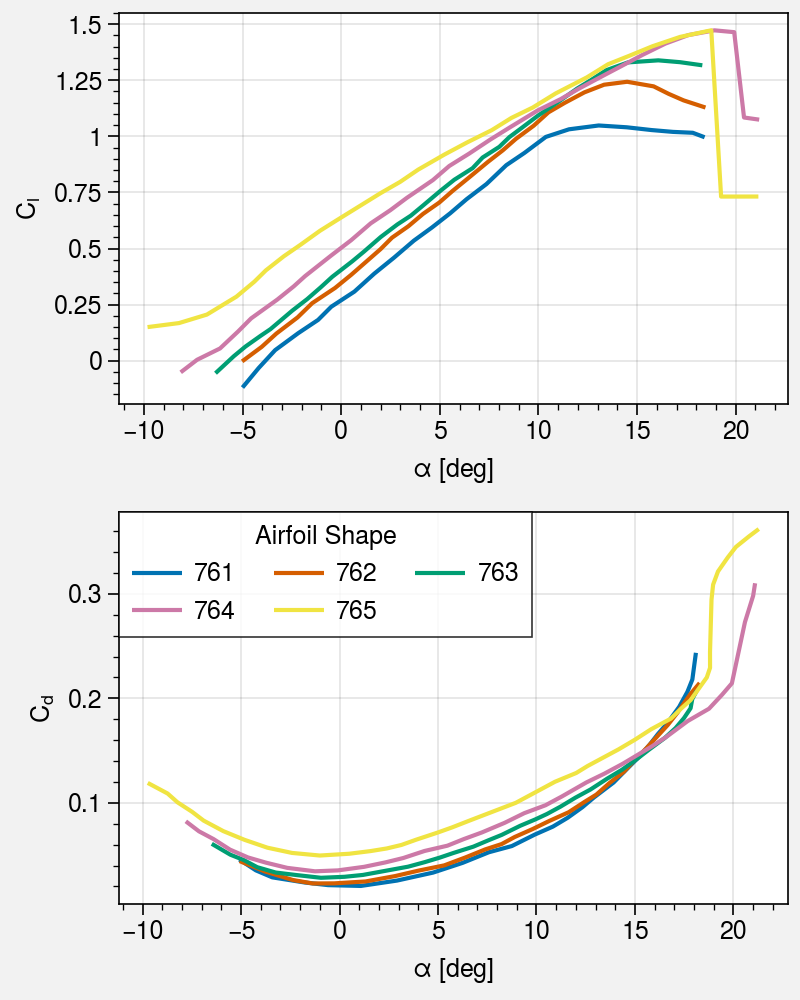

In [129]:
airfoils = ["761", "762", "763", "764", "765"]

fig, axes = plot.subplots(nrows=2, share=0, figsize = (4,5))

# Lift
ax = axes[0]
for airfoil in airfoils:

    cl = load_polar(airfoil_type=airfoil, which="cl")
    cl = pd.DataFrame(data=cl[:, 1], index=cl[:, 0], columns=[airfoil])

    ax.plot(cl)

axes[0].format(ylabel = "$C_l$", xlabel = "$\\alpha$ [deg]")    
# axes[0].legend(title = "Airfoil Shape")

# Drag
ax = axes[1]
for airfoil in airfoils:

    cd = load_polar(airfoil_type=airfoil, which="cd")
    cd = pd.DataFrame(data=cd[:, 1], index=cd[:, 0], columns=[airfoil])

    ax.plot(cd)

axes[1].format(ylabel = "$C_d$", xlabel = "$\\alpha$ [deg]")    
axes[1].legend(title = "Airfoil Shape")

fig.save("Polars.pdf")

In [127]:
WHICH = "cd"

alphas = []
for airfoil in airfoils:
    
    cl = load_polar(airfoil_type=airfoil, which = WHICH)
    alphas.extend(cl[:,0])
    
alphas = set(alphas)
alphas = sorted(list(alphas))
alphas = np.array(alphas)

from scipy.interpolate import interp1d

cls = pd.DataFrame(index= alphas, columns = airfoils)

for airfoil in airfoils:
    
    cl = load_polar(airfoil_type=airfoil, which = WHICH)
    cl = pd.Series(index = cl[:,0], data = cl[:,1])
    
    alpha_min = cl.index.min()
    alpha_max = cl.index.max()
    
    mask_lb = alpha_min <= alphas
    mask_ub = alphas <= alpha_max
    mask = mask_lb & mask_ub
    
    cl = cl.reindex(alphas[mask])
    cl = cl.interpolate(method="index")
    
    cls[airfoil] = cl.copy()
    
cls.index = np.round(cls.index, 4)
print(cls.reindex(cls.index[::3]).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &       761 &       762 &       763 &       764 &       765 \\
\midrule
-9.6455  &       NaN &       NaN &       NaN &       NaN &  0.118141 \\
-7.7208  &       NaN &       NaN &       NaN &  0.081127 &  0.094292 \\
-6.9013  &       NaN &       NaN &       NaN &  0.070388 &  0.083010 \\
-5.9038  &       NaN &       NaN &  0.054380 &  0.059386 &  0.072977 \\
-5.0000  &  0.044650 &       NaN &  0.046322 &  0.050652 &  0.065986 \\
-4.8234  &  0.042479 &  0.042367 &  0.044899 &  0.049203 &  0.064620 \\
-4.1794  &  0.034862 &  0.037387 &  0.038439 &  0.045207 &  0.060458 \\
-3.6602  &  0.030691 &  0.033637 &  0.035610 &  0.042436 &  0.057103 \\
-2.6566  &  0.026465 &  0.027837 &  0.032003 &  0.037805 &  0.053074 \\
-2.1351  &  0.024908 &  0.025407 &  0.030820 &  0.036588 &  0.051609 \\
-1.2453  &  0.022688 &  0.022896 &  0.028949 &  0.034512 &  0.050042 \\
-0.5833  &  0.021284 &  0.022951 &  0.028596 &  0.035014 &  0.050093 \\
 0.2483  &  0.020899 &  0.02